## MTurk Data Generation with MS-COCO Dataset

Note that the `.npy` files are pre-processed and saved from previous Coral experiments (`HazyResearch/coral/visual_genome/`). This notebook goes through the objects in each notebook and filters them. It also adds numbers to each bounding box for Turkers to refer to while writing explanations. Finally, it presents a set of images and valid explanations to test the parser. 

The query of interest is: **The image depicts a person/people biking on a street (in the foreground or background)** 

Note this is different from the Coral experiments since it uses the MS COCO bounding box information, not the captions and annotations from Visual Genome, which were noisy (Coral was accounting for primitive noise as well, so this made sense)


__FOR SOME REASON, THE IMAGES LOADED FROM THE VG DATABASE ARE DIFFERENT FROM THE MSCOCO DATABASE. THEY LOOK THE SAME BUT ARE DIFFERENT SIZES. I THINK. ANYWAY. DONT LOAD VG IMAGES.__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os
import sys
sys.path.append('/dfs/scratch0/paroma/coco')
sys.path.append('/dfs/scratch0/paroma/coco/PythonAPI/')

from pycocotools.coco import COCO
import skimage.io as io
import pylab
import cv2

import pandas as pd
from helper import *

## Load Visual Genome Data
Load the train and validation sets for this task (pre-processed earlier). Split into train and validation based on splits from MS-COCO.

In [2]:
vg_folder = '/dfs/scratch0/paroma/visual_genome/'
train_mscoco = np.load(vg_folder+'train_mscoco.npy')
val_mscoco = np.load(vg_folder+'val_mscoco.npy')

train_ground = np.load(vg_folder+'train_ground.npy')
val_ground = np.load(vg_folder+'val_ground.npy')

In [3]:
#sizes of train-val-test
print "Train Set Size: ", np.shape(train_mscoco)[0], " Positive: ", np.shape(np.where(train_ground == 1))[1] 
print "Val Set Size: ", np.shape(val_mscoco)[0], " Positive: ", np.shape(np.where(val_ground == 1))[1] 

Train Set Size:  903  Positive:  270
Val Set Size:  429  Positive:  86


## Load MS-COCO Data
Load the annotations for train and validation from MS-COCO database.

In [4]:
def generate_anns(filename, coco_ids):
    coco=COCO(filename)
    catIds = coco.getCatIds(catNms=['person','bicycle']);
    set_anns = []

    for set_id in coco_ids:
        annIds = coco.getAnnIds(imgIds=set_id, catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)

        temp_list = []
        for i in xrange(len(anns)):
            temp_dict = {'category_id':anns[i]['category_id'], 'bbox':anns[i]['bbox']}
            temp_list.append(temp_dict)
        set_anns.append(temp_list)
        
    return set_anns

In [5]:
from pycocotools.coco import COCO
coco_path = '/dfs/scratch0/paroma/coco/annotations/'

train_anns = generate_anns(coco_path+'instances_train2014.json', train_mscoco)
val_anns = generate_anns(coco_path+'instances_val2014.json', val_mscoco)

loading annotations into memory...
Done (t=17.25s)
creating index...
index created!
loading annotations into memory...
Done (t=10.85s)
creating index...
index created!


## Visualization Helper Functions

In [34]:
def annotate_image(idx,coco_ids, coco_anns):
    I = io.imread('http://mscoco.org/images/%d'%(coco_ids[idx]))    
    plt.imshow(I); plt.axis('off')
    
    anns = coco_anns[idx]
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    
    for i in xrange(len(anns)):
        obj_anns = anns[i]
        ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                                   obj_anns['bbox'][2],
                                   obj_anns['bbox'][3],
                                   fill=False,
                                   edgecolor='cyan',
                                   linewidth=3))
        plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3,str(i+1), color='cyan', fontsize=24)

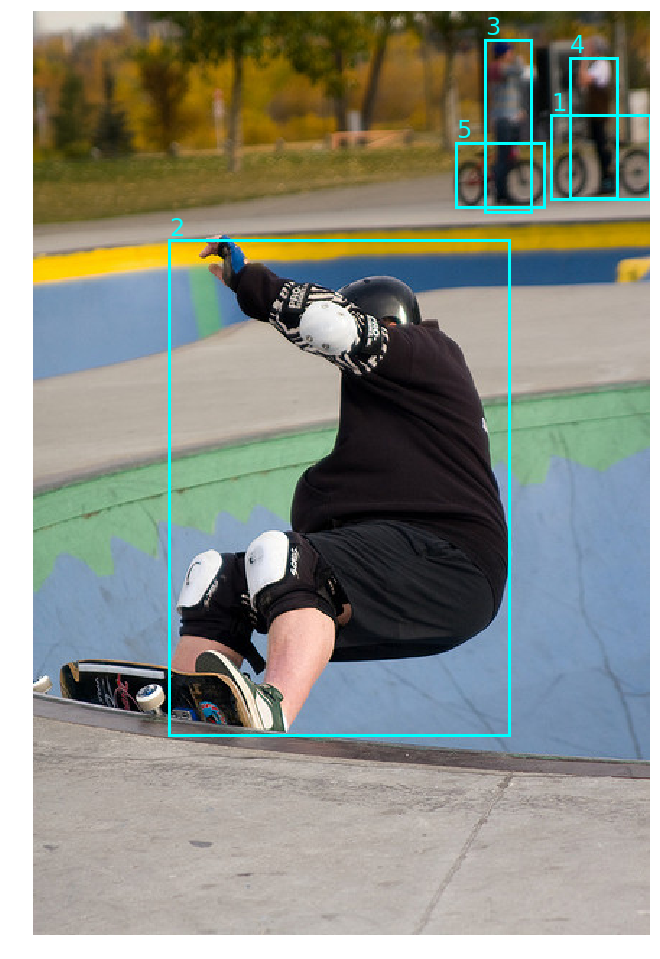

In [38]:
plt.figure(figsize=(480/36,640/36))
annotate_image(11,train_mscoco,train_anns)

### Save Train Images

In [59]:
def save_annotate_image(idx,coco_ids, coco_anns):
    I = io.imread('http://mscoco.org/images/%d'%(coco_ids[idx]))
    h,w = np.shape(I)[0:2]
    plt.figure(figsize=(w/36,h/36))
    plt.imshow(I); plt.axis('off')
    
    anns = coco_anns[idx]
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    
    for i in xrange(len(anns)):
        obj_anns = anns[i]
        ax.add_patch(Rectangle((obj_anns['bbox'][0], obj_anns['bbox'][1]),
                                   obj_anns['bbox'][2],
                                   obj_anns['bbox'][3],
                                   fill=False,
                                   edgecolor='cyan',
                                   linewidth=3))
        plt.text(obj_anns['bbox'][0], obj_anns['bbox'][1]-3,str(i+1), color='cyan', fontsize=24)
    
    plt.savefig('/dfs/scratch0/paroma/visual_genome/train_%d'%(idx), bbox_inches='tight')
    plt.close()

In [60]:
for i in xrange(20):
    save_annotate_image(i,train_mscoco,train_anns)